In [9]:
import awkward as ak
import numpy as np
import time
import coffea
import pickle
import hist

print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from python.plugins import handleData

# redirector = 'root://xcache/'
redirector='root://cmsxrootd.fnal.gov/'
# files = handleData('fileset_QCD.json', redirector, year = 2018, testing = True)
# files = handleData('datasets_UL_NANOAOD.json', redirector, year = 2018, testing = True)
events = NanoEventsFactory.from_root(redirector+'/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/6BEB9A7B-150C-7440-96D8-17A3D87F3225.root', schemaclass=NanoAODSchema).events()
deltaR = events.GenJetAK8.delta_r(events.GenJetAK8.nearest(events.FatJet))[:,0]
deltaRp = events.GenJetAK8[:,0].delta_r(events.GenJetAK8.nearest(events.FatJet)[:,0])
print(deltaR)
print(deltaRp)
# import uproot
# # ### uproot notation
# qcdmc = uproot.open(redirector+'/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/6BEB9A7B-150C-7440-96D8-17A3D87F3225.root')
# jetdata = uproot.open(redirector+"/store/data/Run2016B/JetHT/NANOAOD/ver2_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/2520000/01B677EC-4D6C-FB45-BD57-C99F3812767F.root")
# uprootevents_data = jetdata['Events']
# uprootevents = qcdmc['Events']
# # print(uprootevents_data.keys('*eight*'))
# print(uprootevents.keys('*PU*'))
# # for key in
# print(uprootevents["L1PreFiringWeight_Nom"].array())
# print(len(uprootevents_data["L1PreFiringWeight_Nom"].array()))

0.7.21
[0.00309, 0.0171, 0.0208, 0.00294, 0.0203, ... 0.00115, 0.00549, 0.0104, 0.00678]
[0.00309, 0.0171, 0.0208, 0.00294, 0.0203, ... 0.00115, 0.00549, 0.0104, 0.00678]


In [14]:
from python.plugins import *
from python.trijetProcessor import makeTrijetHists
from dask.distributed import Client


data = True
winterfell = False
casa = False
dask = True
testing= False
year="2018"
btag_str = 'None'
processor = makeTrijetHists(data = data, btag = btag_str)
datastring = "JetHT" if processor.do_gen == False else "QCDsim"
if processor.do_gen==True and winterfell:
    filename = "QCD_flat_files.json"
elif processor.do_gen==True:
    filename = "fileset_QCD.json"
else:
    filename = "datasets_UL_NANOAOD.json"
    
if year == 2016 or year == 2017 or year == 2018:
    year_str = str(year)
elif year == "2016" or year == "2016APV" or year == "2017" or year == "2018":
    year_str = year
else:
    year_str = "All"

if testing and not data:
    fname = 'coffeaOutput/trijetHistsTest_wXSscaling_{}_pt{}_rapidity{}_{}HEMveto{}.pkl'.format(datastring, processor.ptcut, processor.ycut, processor.btag, year_str)
elif testing and data:
    fname = 'coffeaOutput/trijetHistsTest{}_pt{}_rapidity{}_{}HEMveto{}.pkl'.format(datastring, processor.ptcut, processor.ycut, processor.btag, year_str)
elif not testing and data:
    fname = 'coffeaOutput/trijetHists_{}_pt{}_rappidity{}_{}HEMveto{}.pkl'.format(datastring, processor.ptcut, processor.ycut, processor.btag, year_str)
else:
    fname = 'coffeaOutput/trijetHists_wXSscaling_{}_pt{}rapidity{}_{}HEMveto{}.pkl'.format(datastring, processor.ptcut, processor.ycut, processor.btag, year_str)

Data:  True  gen  False
mreco bins:  [0.00e+00 5.00e-01 1.00e+00 3.00e+00 5.00e+00 7.50e+00 1.00e+01 1.50e+01
 2.00e+01 3.00e+01 4.00e+01 5.00e+01 6.00e+01 7.00e+01 8.00e+01 9.00e+01
 1.00e+02 1.25e+02 1.50e+02 1.75e+02 2.00e+02 2.25e+02 2.50e+02 6.25e+02
 1.00e+03]


In [15]:
# %%capture cap
result = runCoffeaJob(processor, jsonFile = filename, casa=casa, winterfell = winterfell, dask = dask, year=year, testing = testing, data = not processor.do_gen)
with open(fname, "wb") as f:
    pickle.dump( result, f)
# with open('trijet_'+datastring+year_str+processor.btag+'output.txt', 'w') as f:
#     f.write(cap)

Running on LPC Condor
{'alljet_ptreco_mreco': Hist(############] | 100% Completed |  1hr  0min 58.4s
  StrCategory([], growth=True, name='dataset', label='Dataset'),
  StrCategory([], growth=True, name='jetNumb', label='Jet'),
  StrCategory([], growth=True, name='partonFlav', label='Parton Flavour'),
  Variable(array([0.00e+00, 5.00e-01, 1.00e+00, 3.00e+00, 5.00e+00, 7.50e+00,
       1.00e+01, 1.50e+01, 2.00e+01, 3.00e+01, 4.00e+01, 5.00e+01,
       6.00e+01, 7.00e+01, 8.00e+01, 9.00e+01, 1.00e+02, 1.25e+02,
       1.50e+02, 1.75e+02, 2.00e+02, 2.25e+02, 2.50e+02, 6.25e+02,
       1.00e+03]), name='mreco', label='m_{RECO} (GeV)'),
  Variable([200, 280, 360, 450, 520, 630, 690, 750, 800, 1300, 13000], name='ptreco', label='p_{T,RECO} (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'btag_eta': Hist(
  StrCategory([], growth=True, name='dataset', label='Dataset'),
  StrCategory([], growth=True, name='jetNumb', label='Jet'),
  StrCategory([], growth=True, name='parton

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
# fname = "coffeaOutput/trjetHistsTest_QCDsim_200.0_2.4_NewHist.pkl"
with open(fname, "rb") as f:
    result = pickle.load( f )
# print(result)
os_path = 'plots/selectionStudies/trijet/'
checkdir(os_path)

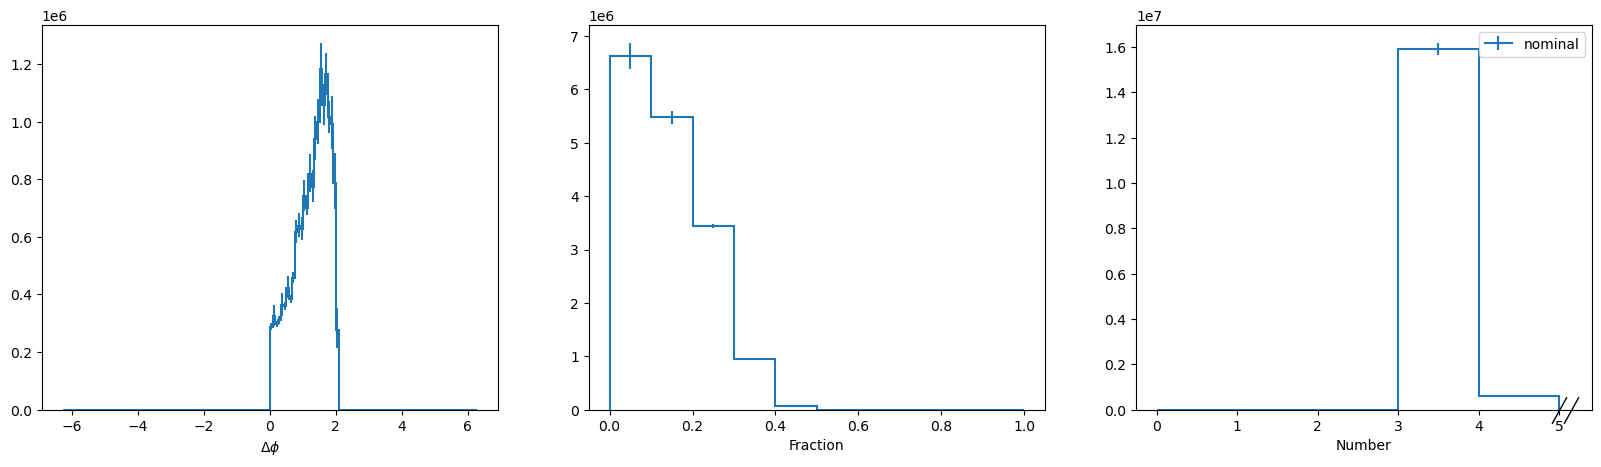

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
if not data:
    fig, axs = plt.subplots(1, 3)
    result['dphimin_gen'][{'dataset':sum}].plot1d(ax = axs[0], density=True)
    result['asymm_gen'][{'dataset':sum}].plot1d(ax=axs[1], density=True)
    result['njet_gen'][{'dataset':sum}].plot1d(ax=axs[2], density=True)
    plt.legend()

fig, axs = plt.subplots(1, 3)
result['dphimin_reco'][{'dataset':sum}].plot1d(ax = axs[0])
result['asymm_reco'][{'dataset':sum}].plot1d(ax=axs[1])
result['njet_reco'][{'dataset':sum}].plot1d(ax=axs[2])
plt.legend()

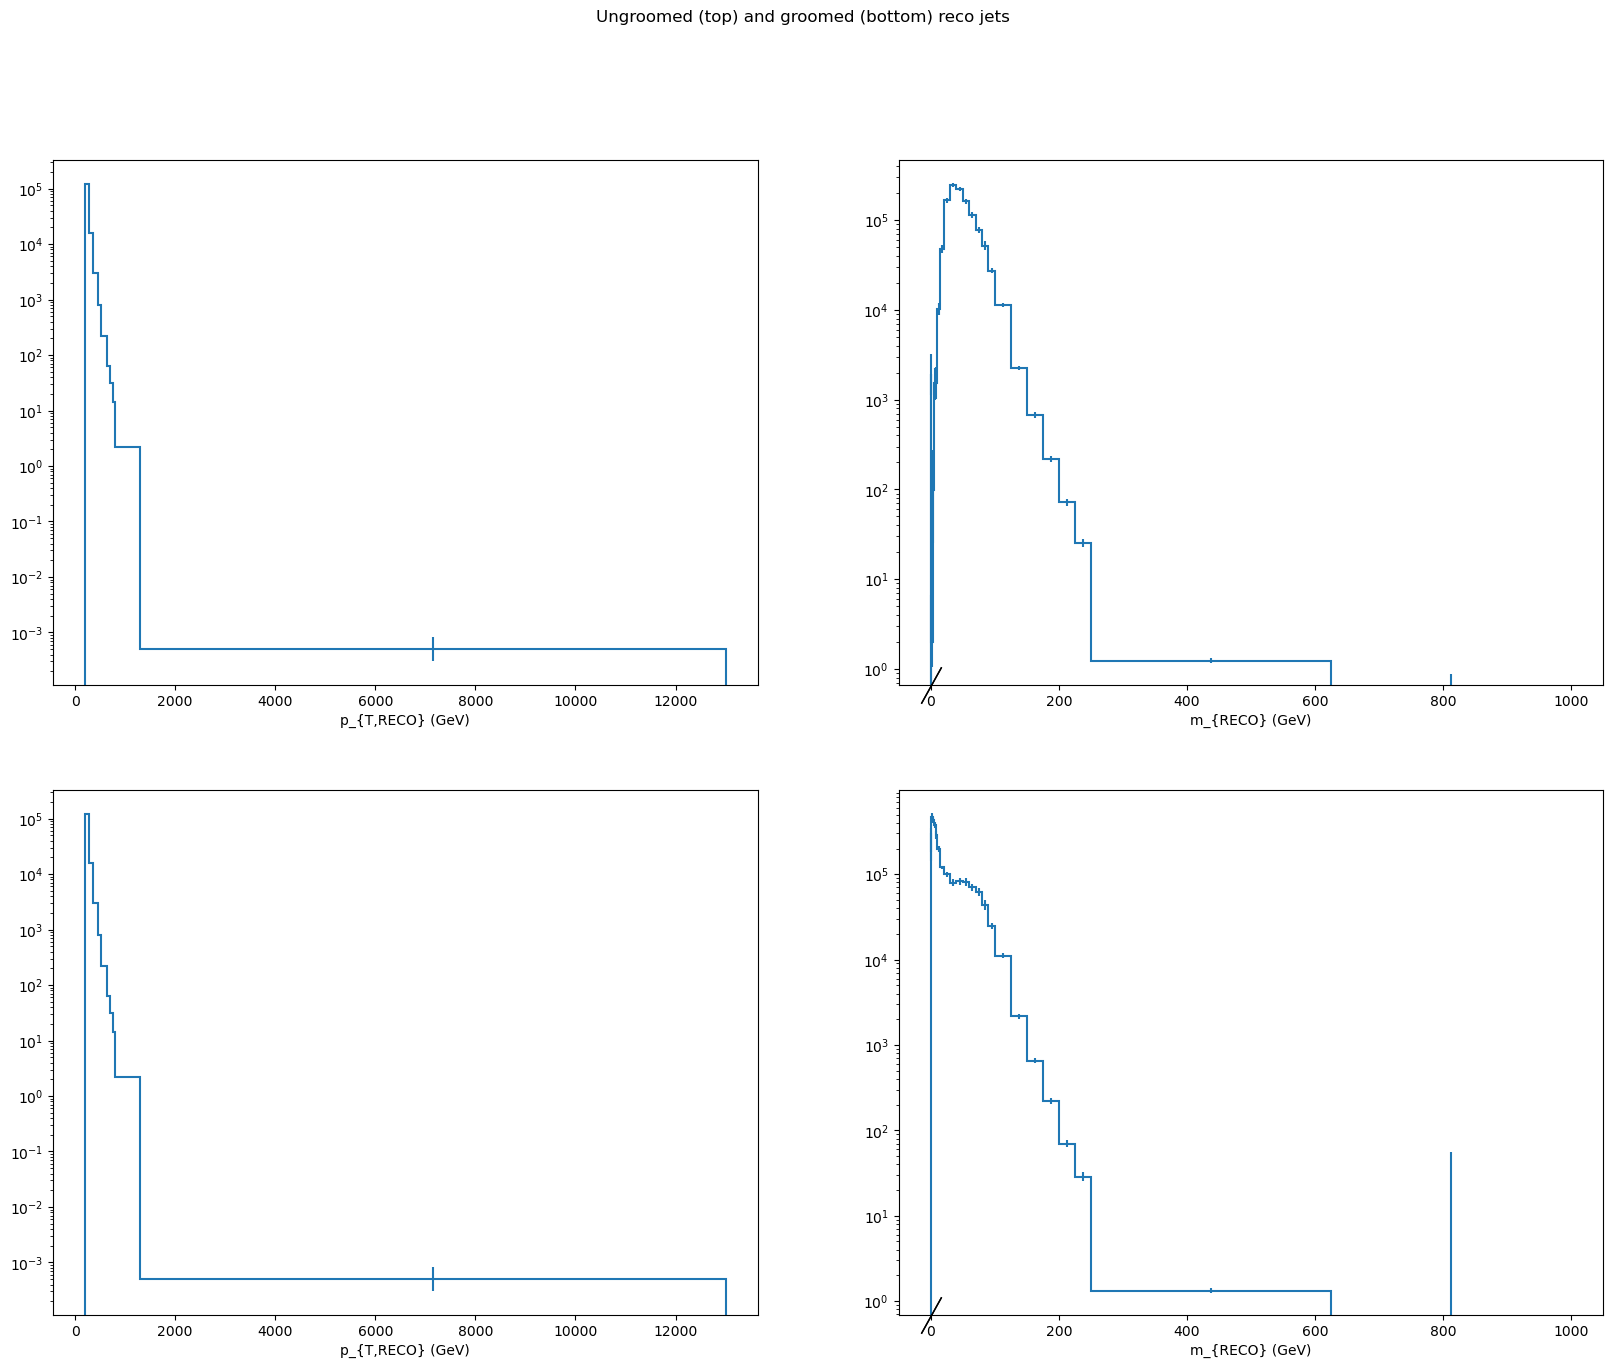

In [18]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Ungroomed (top) and groomed (bottom) reco jets')
result['jet_pt_mass_reco_u'][{'dataset':sum}].project('ptreco').plot1d(ax=axs[0,0], binwnorm=True)
result['jet_pt_mass_reco_u'][{'dataset':sum}].project('mreco').plot1d(ax=axs[0,1], binwnorm=True)
result['jet_pt_mass_reco_g'][{'dataset':sum}].project('ptreco').plot1d(ax=axs[1,0], binwnorm=True)
result['jet_pt_mass_reco_g'][{'dataset':sum}].project('mreco').plot1d(ax=axs[1,1], binwnorm=True)
axs[0,0].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[0,1].set_yscale('log')
plt.savefig(os_path+"/test_pt_m_gen_u_g.png")

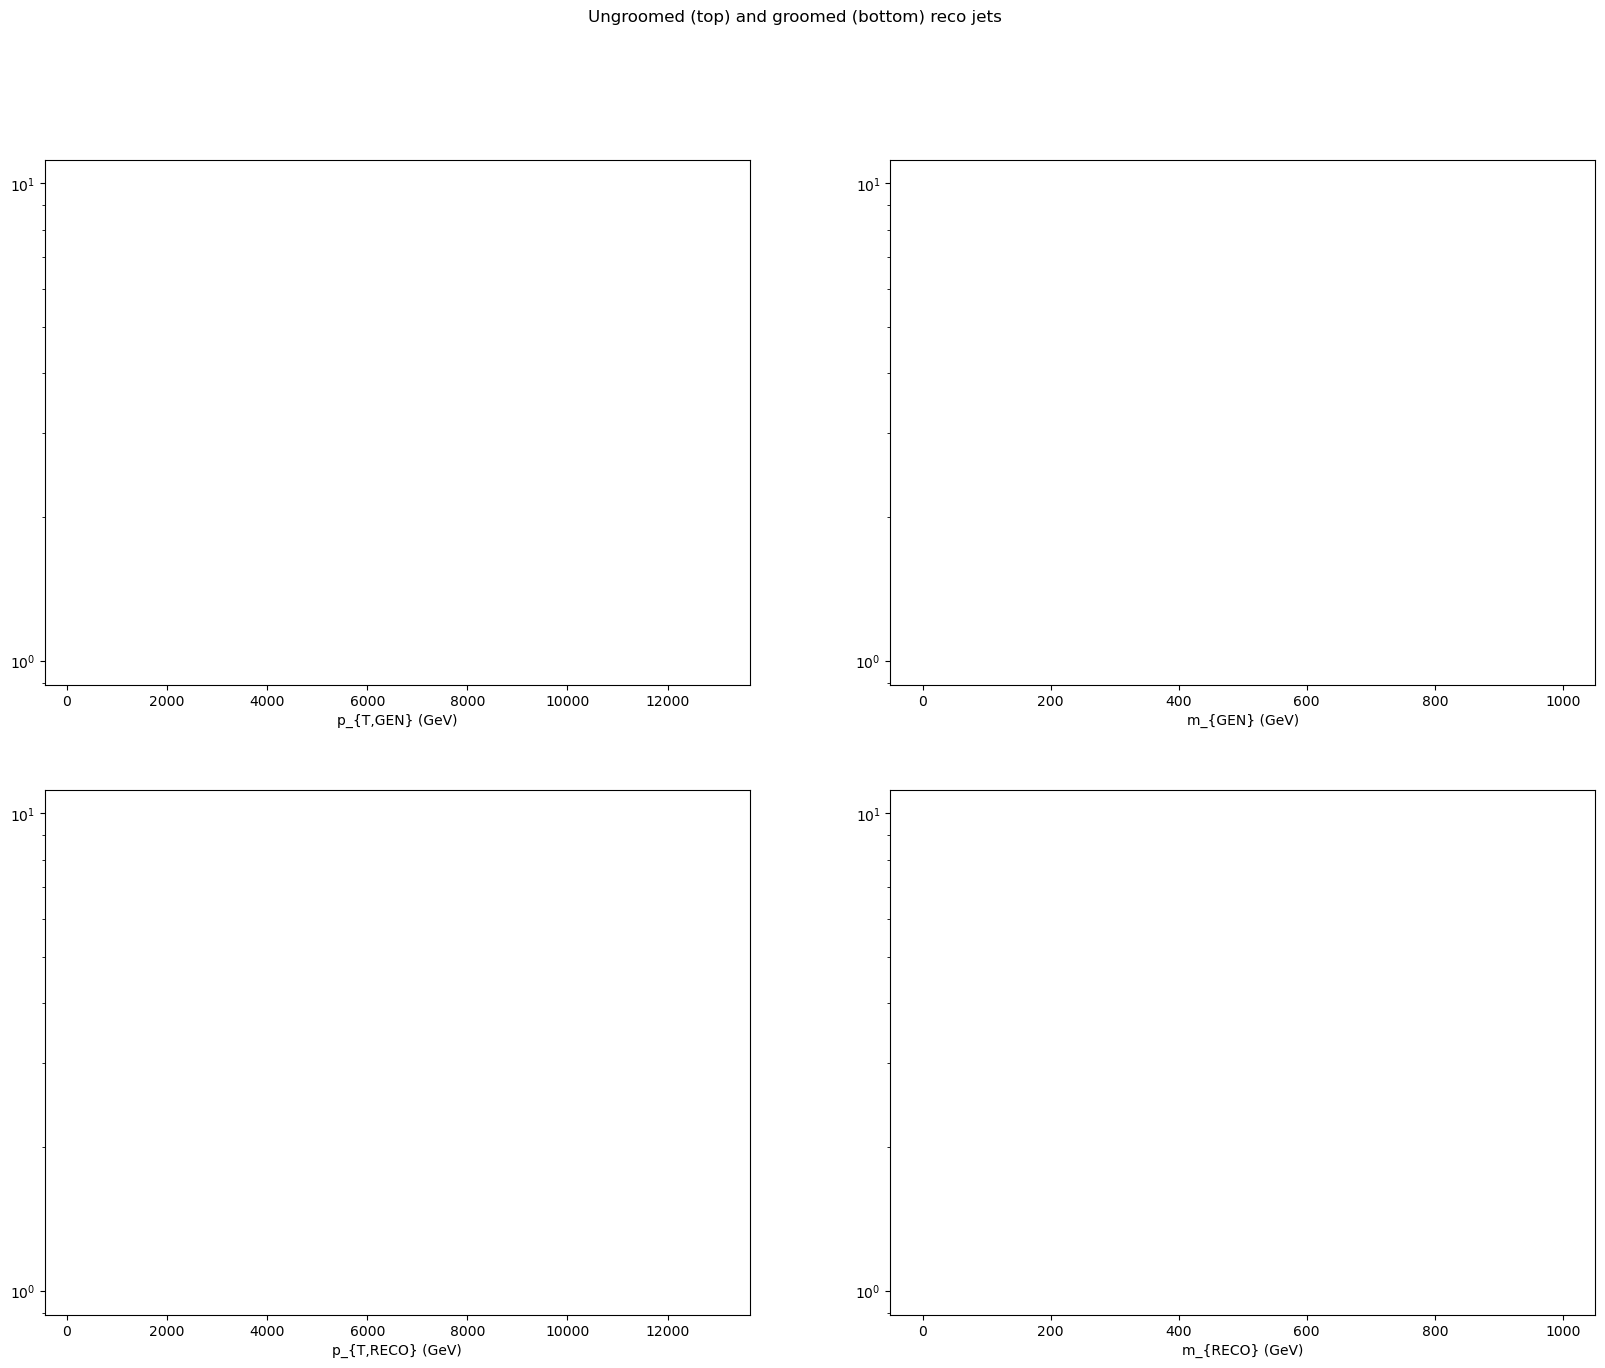

In [19]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Ungroomed (top) and groomed (bottom) reco jets')
result['misses'][{'dataset':sum}].project('ptgen').plot1d(ax=axs[0,0])
result['misses'][{'dataset':sum}].project('mgen').plot1d(ax=axs[0,1])
result['fakes'][{'dataset':sum}].project('ptreco').plot1d(ax=axs[1,0])
result['fakes'][{'dataset':sum}].project('mreco').plot1d(ax=axs[1,1])
axs[0,0].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')
axs[0,1].set_yscale('log')

### Plotting Response Matrices

 ┌───────────────────────────────────────────────────────────────────────────┐
 └───────────────────────────────────────────────────────────────────────────┘


ValueError: Must have only 1 or 2 axes

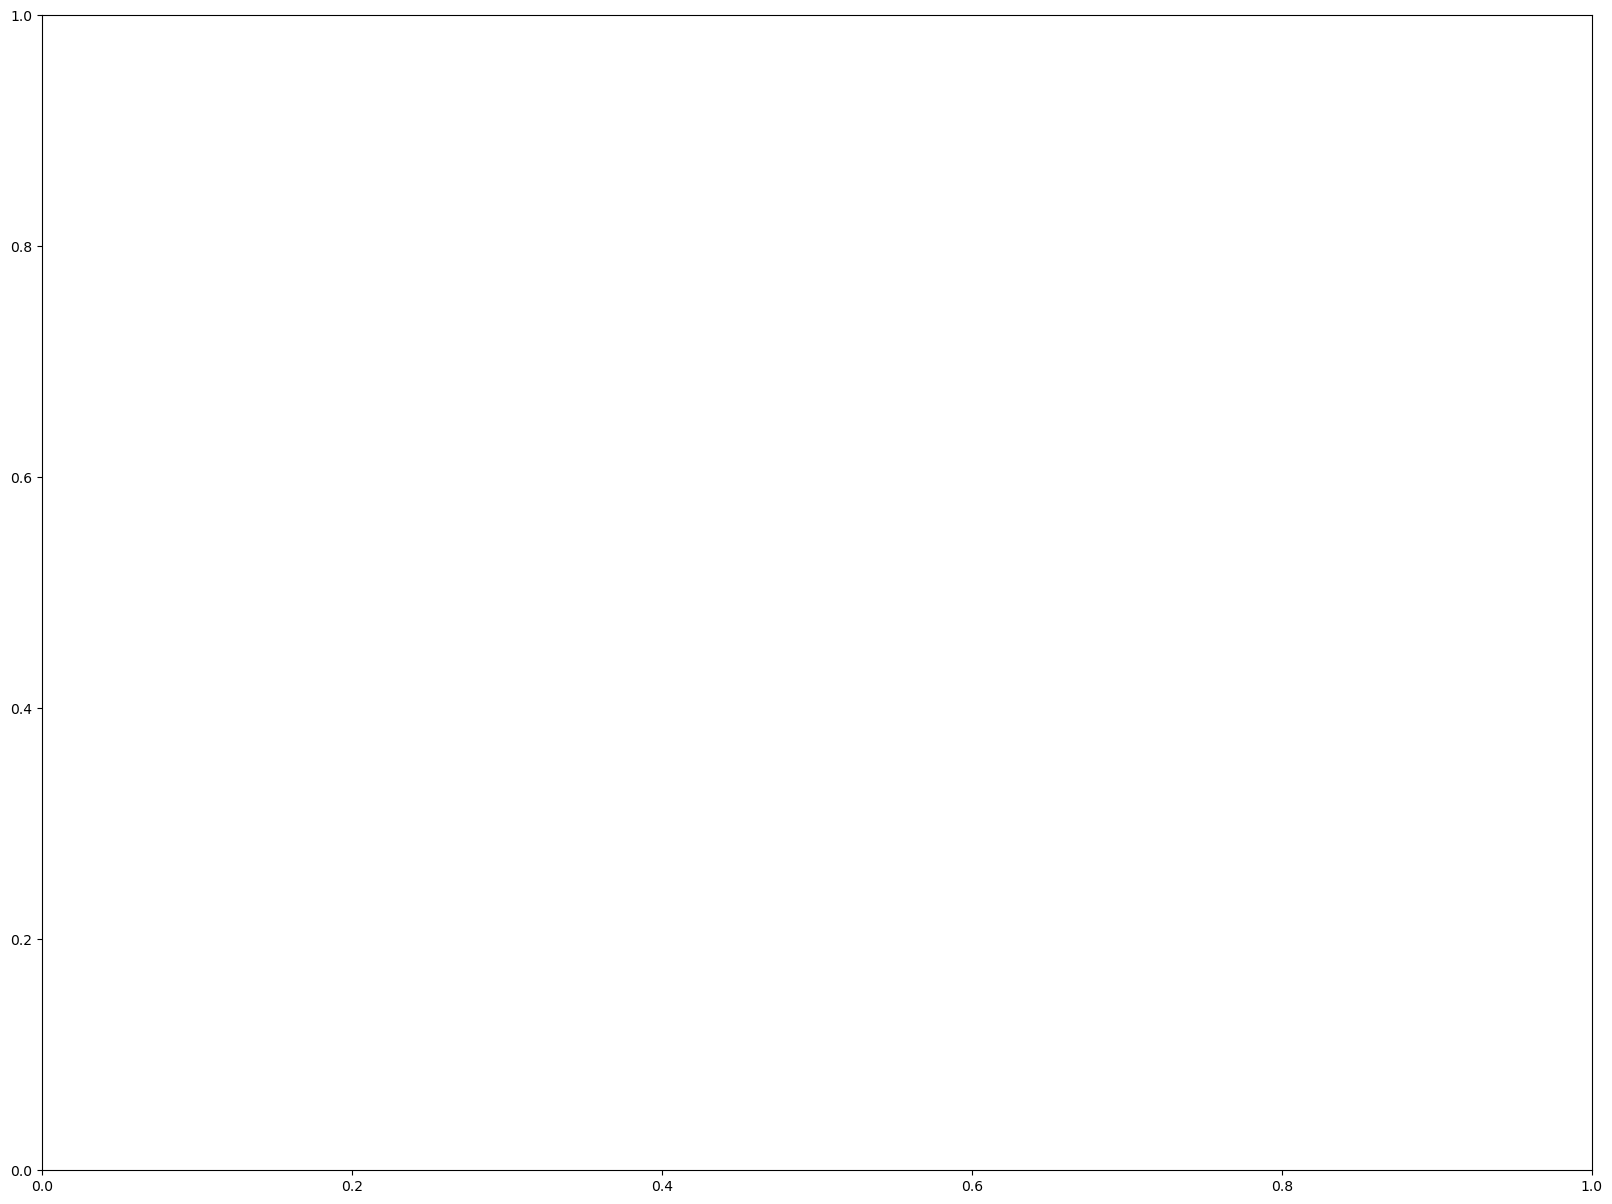

In [20]:
data = False
if not data:
    response_matrix_u_values = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").values()
    response_matrix_g_values = result['response_matrix_g'].project("ptreco", "mreco", "ptgen", "mgen").values()
    print(result['response_matrix_u'][{"ptreco":1, "ptgen":2,"mreco":5, "mgen":10, "dataset":sum}])
    response_matrix_np_vals_u, ptreco_edges, mreco_edges, ptgen_edges, mgen_edges = result['response_matrix_u'].project("ptreco", "mreco", "ptgen", "mgen").to_numpy()
    result['response_matrix_u'][{"ptreco":0, "ptgen":0,"dataset":sum}].plot2d()
    plt.show()
    result['response_matrix_u'][{"ptreco":sum, "ptgen":sum,"dataset":sum}].plot2d()
    plt.show()
    nptreco,nmassreco,nptgen,nmassgen = response_matrix_u_values.shape
    print(response_matrix_u_values.shape)
    response_matrix_g_final = response_matrix_g_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )
    response_matrix_u_final = response_matrix_u_values.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) ) 
    print("Max ungroomed value np ", np.max(response_matrix_u_final))
    print("Location of max cal in 4d array :", np.argwhere(response_matrix_np_vals_u==49) )
    print(response_matrix_np_vals_u[0,9,0,4])
    print("Location of max cal in 2d array :", np.argwhere(response_matrix_u_final==49) )
    print(response_matrix_u_final[9,4])
    print("Location of max cal in 2d array :", np.argwhere(response_matrix_u_final.flatten()==49) )
    print(9*nmassgen*nptgen+4)
    print(response_matrix_u_final.flatten()[9*nmassgen*nptgen+4])
    ptreco_centers = (ptreco_edges[:-1]+ptreco_edges[1:])/2
    mreco_centers = (mreco_edges[:-1]+mreco_edges[1:])/2
    ptgen_centers = (ptgen_edges[:-1]+ptgen_edges[1:])/2
    mgen_centers = (mgen_edges[:-1]+mgen_edges[1:])/2
    response_matrix_bins = np.ones(np.append(response_matrix_u_values.shape,4))
    response_matrix_ptreco_bins = np.ones_like(response_matrix_u_values)
    print(response_matrix_ptreco_bins.ndim)
    response_matrix_mreco_bins = np.ones_like(response_matrix_u_values)
    response_matrix_ptgen_bins = np.ones_like(response_matrix_u_values)
    response_matrix_mgen_bins = np.ones_like(response_matrix_u_values)
    for ipt in np.arange(len(ptreco_centers)):
        for im in np.arange(len(mreco_centers)):
            for jpt in np.arange(len(ptgen_centers)):
                for jm in np.arange(len(mgen_centers)):
                    response_matrix_ptreco_bins[ipt,im,jpt,jm] = ptreco_centers[ipt]
                    response_matrix_mreco_bins[ipt][im][jpt][jm] = mreco_centers[im]
                    response_matrix_ptgen_bins[ipt][im][jpt][jm] = ptgen_centers[jpt]
                    response_matrix_mgen_bins[ipt][im][jpt][jm] = mgen_centers[jm]
                    response_matrix_bins[ipt][im][jpt][jm] = [ptreco_centers[ipt], mreco_centers[im], ptgen_centers[jpt], mgen_centers[jm]]
    response_matrix_ptreco_bins = response_matrix_ptreco_bins.reshape((nptreco)*(nmassreco), (nptgen)*(nmassgen))
    response_matrix_mgen_bins = response_matrix_mgen_bins.reshape((nptreco)*(nmassreco), (nptgen)*(nmassgen))
    response_matrix_bins = response_matrix_bins.reshape((nptreco)*(nmassreco), (nptgen)*(nmassgen), 4)
    print(response_matrix_bins[1][:10])
    print(response_matrix_ptreco_bins[1][:10])
    print(response_matrix_mgen_bins[1][:10])

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow( np.log(response_matrix_u_final+1), vmax=10, aspect="equal", cmap="Blues" )
plt.xlabel("GEN", fontsize=10)
plt.ylabel("RECO", fontsize=10)
plt.tick_params(labelsize=20)

In [ ]:
result['fakes'][{"dataset":sum}].plot2d()
plt.show()
result['misses'][{"dataset":sum}].plot2d()
plt.show()
result['misses'][{"dataset":sum}].plot2d()
plt.show()

In [ ]:
nbins_ptreco = len(result['response_matrix_u'].project("ptreco").values())
nbins_mreco = len(result['response_matrix_u'].project("mreco").values())
pt_reco_bins, pt_reco_edges = result['response_matrix_u'].project("ptreco").to_numpy()
pt_gen_bins, pt_gen_edges = result['response_matrix_u'].project("ptgen").to_numpy()
print("Pt reco bins and edges: ", pt_reco_bins, pt_reco_edges)
print("Pt gen bins and edges: ", pt_gen_bins, pt_gen_edges)
print(len(pt_gen_edges), nbins_ptreco)
m_reco_bins, m_reco_edges = result['response_matrix_u'].project("mreco").to_numpy()
m_gen_bins, m_gen_edges = result['response_matrix_u'].project("mgen").to_numpy()
print("M reco bins and edges: ", m_reco_bins, m_reco_edges)
print("M gen bins and edges: ", m_gen_bins, m_gen_edges)
print(len(m_reco_edges), nbins_mreco)
print(len(m_gen_edges), nbins_mgen)

In [ ]:
#Response matrix indexing test
axis0 = hist.axis.Regular(2, 0, 2, overflow=False, underflow=False, name="A")
axis1 = hist.axis.Regular(2, 0, 2, overflow=False, underflow=False, name="B")
axis2 = hist.axis.Regular(2, 0, 2, overflow=False, underflow=False, name="C")
axis3 = hist.axis.Regular(2, 0, 2, overflow=False, underflow=False, name="D")
test_hist = hist.Hist(axis0, axis1, axis2, axis3)
vala = [0.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
valb = [0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
valc = [0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
vald = [0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.5]
test_hist.fill(A = vala, B = valb, C = valc, D = vald)
print(test_hist.project("A", "B").values())
print(test_hist.project("B").values())
print(test_hist.project("C").values())
print(test_hist.project("D").values())
print(test_hist.values())
print(test_hist[{"A":1,"B":1,"C":1, "D":1}])

In [ ]:
tot_bins = nbins_ptreco*nbins_ptgen
print(tot_bins)
nbins = 0
for i in np.arange(len(reco_edges)-1):
    for j in np.arange(len(gen_edges)-1):
        print("Bin (", i, ",", j, ")")
        result['response_matrix_u'][{'dataset':sum, 'ptreco':i, 'ptgen':j}].plot2d()
        nbins=nbins+1
        plt.show()
print(nbins)

In [ ]:
if not data:
    plt.figure(figsize = (40,80))
    plt.imshow( np.log(response_matrix_u_final+1), aspect="equal", cmap="Blues" )
    plt.xlabel("RECO", fontsize=50)
    plt.ylabel("GEN", fontsize=50)
    plt.tick_params(labelsize=40)

In [ ]:
if not data:
    plt.figure(figsize = (40,80))
    plt.imshow( np.log(response_matrix_g_final+1), aspect="equal", cmap="Blues" )
    plt.xlabel("RECO", fontsize=50)
    plt.ylabel("GEN", fontsize=50)
    plt.tick_params(labelsize=40)

In [ ]:
if not data:
    plt.figure(figsize = (40,80))
    plt.imshow( response_matrix_u_final, aspect="equal", cmap="Blues" )
    plt.xlabel("RECO", fontsize=50)
    plt.ylabel("GEN", fontsize=50)
    plt.tick_params(labelsize=40)

In [ ]:


plt.rcParams["figure.figsize"] = (20,20)
fig = plt.figure()
grid = fig.add_gridspec(2,2, figure=fig, wspace=0.1, hspace=0.1)
grid00 = grid[0,0].subgridspec(4,1, wspace=0, hspace=0)
grid01 = grid[0,1].subgridspec(4,1, wspace=0, hspace=0)
grid10 = grid[1,0].subgridspec(4,1, wspace=0, hspace=0)
grid11 = grid[1,1].subgridspec(4,1, wspace=0, hspace=0)
        
numerator = result['jet_pt'][{'partonFlav':'Gluon'}].project('ptgen')
denominator = result['jet_pt'].project('ptgen')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid00[:-1, :])
subplot_ax = fig.add_subplot(grid00[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Pt all jets(GeV)")
plt.ylabel("Gluon fraction")

numerator = result['jet_pt'][{'partonFlav':'Gluon', 'jetNumb':'jet3'}].project('ptgen')
denominator = result['jet_pt'][{'jetNumb':'jet3'}].project('ptgen')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid01[:-1, :])
subplot_ax = fig.add_subplot(grid01[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Pt for jet3 (GeV)")
plt.ylabel("Gluon fraction")


numerator = result['jet_pt'][{'partonFlav':'Gluon', 'jetNumb':'jet2'}].project('ptgen')
denominator = result['jet_pt'][{'jetNumb':'jet2'}].project('ptgen')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid10[:-1, :])
subplot_ax = fig.add_subplot(grid10[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Pt for jet2 (GeV)")
plt.ylabel("Gluon fraction")


numerator = result['jet_pt'][{'partonFlav':'Gluon', 'jetNumb':'jet1'}].project('ptgen')
denominator = result['jet_pt'][{'jetNumb':'jet1'}].project('ptgen')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid11[:-1, :])
subplot_ax = fig.add_subplot(grid11[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Pt for jet1 (GeV)")
plt.ylabel("Gluon fraction")
fig.suptitle('Gluon content as a function of pT')
plt.savefig(os_path + "gluonPtFrac.png")

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.gcf()
grid = fig.add_gridspec(2,2, figure=fig, wspace=0.1, hspace=0.1)
grid00 = grid[0,0].subgridspec(4,1, wspace=0, hspace=0)
grid01 = grid[0,1].subgridspec(4,1, wspace=0, hspace=0)
grid10 = grid[1,0].subgridspec(4,1, wspace=0, hspace=0)
grid11 = grid[1,1].subgridspec(4,1, wspace=0, hspace=0)

numerator = result['jet_eta'][{'partonFlav':'Gluon'}].project('eta')
denominator = result['jet_eta'].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid00[:-1, :])
subplot_ax = fig.add_subplot(grid00[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta all jets(GeV)")
plt.ylabel("Gluon fraction")

numerator = result['jet_eta'][{'partonFlav':'Gluon', 'jetNumb':'jet3'}].project('eta')
denominator = result['jet_eta'][{'jetNumb':'jet3'}].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid01[:-1, :])
subplot_ax = fig.add_subplot(grid01[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta for jet3 (GeV)")
plt.ylabel("Gluon fraction")


numerator = result['jet_eta'][{'partonFlav':'Gluon', 'jetNumb':'jet2'}].project('eta')
denominator = result['jet_eta'][{'jetNumb':'jet2'}].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid10[:-1, :])
subplot_ax = fig.add_subplot(grid10[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta for jet2 (GeV)")
plt.ylabel("Gluon fraction")


numerator = result['jet_eta'][{'partonFlav':'Gluon', 'jetNumb':'jet1'}].project('eta')
denominator = result['jet_eta'][{'jetNumb':'jet1'}].project('eta')
print(numerator.values(), denominator.values())

numerator.label = r'$\epsilon$'

main_ax = fig.add_subplot(grid11[:-1, :])
subplot_ax = fig.add_subplot(grid11[-1, :], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
main_ax, sublot_ax = numerator.plot_ratio(
    denominator,
    rp_num_label="gluons",
    rp_denom_label="all",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax}
)

plt.xlabel("Eta for jet1 (GeV)")
plt.ylabel("Gluon fraction")
fig.suptitle('Gluon content as a function of eta')
plt.savefig(os_path+'/gluonEtaFrac' + ".png")

In [ ]:
#sum entries in bins --> plot as y-axis
plt.rcParams["figure.figsize"] = (20,5)


fig, axs = plt.subplots(1, 3)
result['jet_mass'][{'jetNumb':sum, 'dataset':sum}].plot1d(ax = axs[0], overlay='partonFlav')
plt.rc('legend',fontsize='small')
plt.xlabel("Jet mass (GeV)")
result['jet_pt'][{'jetNumb':sum, 'dataset':sum}].plot1d(ax = axs[1], overlay='partonFlav')
plt.rc('legend',fontsize='small')
#axs[0].set_xlabel("Jet mass (GeV)")
plt.xlabel("Jet pT (GeV)")
result['jet_eta'][{'jetNumb':sum, 'dataset':sum}].plot1d(ax = axs[2], overlay='partonFlav')
plt.rc('legend',fontsize='small')
plt.legend()
plt.xlabel("Jet eta (GeV)")

print(axs)

fig.suptitle('Trijet eta <2.5, pt> 200.', fontsize="large")
plt.savefig(os_path+'/allJetPtEtaPhi_partons' + ".png")

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(3, 3)
print(result['jet_mass'])
result['jet_mass'][{'jetNumb':'jet1', 'dataset':sum}].plot1d(ax = axs[0,0], overlay='partonFlav')
plt.rc('legend',fontsize='small')
axs[0,0].set_xlabel("Jet1 mass (GeV)")
result['jet_pt'][{'jetNumb':'jet1', 'dataset':sum}].plot1d(ax = axs[0,1], overlay='partonFlav')
axs[0,1].set_xlabel("Jet1 pT (GeV)")
result['jet_eta'][{'jetNumb':'jet1', 'dataset':sum}].plot1d(ax = axs[0,2], overlay='partonFlav')
axs[0,2].set_xlabel("Jet1 eta (GeV)")
result['jet_mass'][{'jetNumb':'jet2', 'dataset':sum}].plot1d(ax = axs[1,0], overlay='partonFlav')
axs[1,0].set_xlabel("Jet2 mass (GeV)")
result['jet_pt'][{'jetNumb':'jet2', 'dataset':sum}].plot1d(ax = axs[1,1], overlay='partonFlav')
axs[1,1].set_xlabel("Jet2 pT (GeV)")
result['jet_eta'][{'jetNumb':'jet2', 'dataset':sum}].plot1d(ax = axs[1,2], overlay='partonFlav')
axs[1,2].set_xlabel("Jet2 eta (GeV)")
result['jet_mass'][{'jetNumb':'jet3', 'dataset':sum}].plot1d(ax = axs[2,0], overlay='partonFlav')
axs[2,0].set_xlabel("Jet3 mass (GeV)")
result['jet_pt'][{'jetNumb':'jet3', 'dataset':sum}].plot1d(ax = axs[2,1], overlay='partonFlav')
axs[2,1].set_xlabel("Jet3 pT (GeV)")
result['jet_eta'][{'jetNumb':'jet3', 'dataset':sum}].plot1d(ax = axs[2,2], overlay='partonFlav')
axs[2,2].set_xlabel("Jet3 eta (GeV)")
for ax in axs.flatten():
    ax.legend()
print(axs)
fig.suptitle('Dijet eta <2.5, pt> 200.', fontsize="large")
plt.savefig(os_path+'/singleJetPtEtaPhi_partons' + ".png")

In [ ]:
# plt.rcParams["figure.figsize"] = (20,5)


# fig, axs = plt.subplots(1, 3)
print(result['jet_mass'][{'jetNumb':sum, 'dataset':sum}])
result['jet_mass'][{'dataset':sum, "partonFlav":sum}].plot1d(density=True, overlay='jetNumb')
plt.legend()
#axs[0].set_xlabel("Jet mass (GeV)")
plt.xlabel("Jet mass (GeV)")

In [ ]:
# plot mass after summing over partons

In [ ]:
fig, ax = plt.subplots(1, 1)
result['btag'][{'jetNumb':'jet3', 'dataset':sum}].plot1d(overlay="partonFlav")
ax.set_xlabel("Jet3 b-tag disc.")
plt.legend()
#can do an anti b-tag --> inverse of recommendation

In [ ]:
njets=result['cutflow']['n3Jets']
ngluonjets=result['cutflow']['nGluonJets']
print(result['cutflow'])
print("Gluon purity:", ngluonjets/njets)

#plot pt, eta, phi, fake rate, pt efficiency, gluon purity for difference selections with b tags for all jets 
#and each individual jet in the 3 jets